# FYS-STK4155 - Project 1

## By Jørn Marcus Høylo Rosenberg and Andreas Dyve

This Notebook contains both the code for the project and the report. The notebook is structured with each exercise in its own cell(s). This leads to some repeting code, but is practical for the purpose of evaluating each task seperately. (eller noe i denne duren? Fin den)

### Table of Contents

* [1. Imported libraries](#imports)
* [2. Functions used throughout the project](#functions)
    * [2.1. Franke function](#frankefunction)
    * [2.2. Cost functions](#costfunctions) 
    * [2.3. Design matrix function](#Xfunction)
    * [2.4. Scaling function](#scalefunction)
* [3. Exercise 1](#3)
    * [3.1. OLS regression](#3.1)
    * [3.2. Confidence intervals](#3.2)
    * [3.3. Discussion on scaling](3.3)
* [4. Exercise 2](#4)
    * [4.1. Train vs test mse as function of complexity](#4.1)
    * [4.1. OLS regression with bootstrap](#4.2)
    * [4.2. bias-variance trade-off](#4.3)
* [5. Exercise 3](#5)
    * [5.1. OLS regression with cross-validation](#5.1)
    * [5.2. Comparison with bootstrap](#5.2)
* [6. Exercise 4](#6)
    * [6.1. Ridge regression with bootstrap and cross-validation](#6.1)
    * [6.2. Discussion of lambda](#6.2)
* [7. Exercise 5](#7)
    * [7.1 Lasso regression with bootstrap and cross-validation](#7.1)
    * [7.2 Evaluation of models](#7.2)
* [8. Exercise 6](#8)

### 1. Imported libraries <a class="anchor" id="imports"></a>

In [2]:
import numpy as np
from random import random, seed
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from sklearn.utils import resample

### 2. Functions used throughout the project <a class="anchor" id="functions"></a>

The following functions are used for much of the repetative tasks in this project

#### 2.1. Error functions <a class="anchor" id="errorfunctions"></a>

In [3]:
def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)
def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

#### 2.2. Franke function <a class="anchor" id="frankefunction"></a>

The provided code in the exercise set is used for making of the Franke function.

In [4]:
def FrankeFunction(x,y,noise_coef):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    noise = noise_coef * np.random.randn(N*N)
    return term1 + term2 + term3 + term4 + noise

#### 2.3. Design matrix function <a class="anchor" id="Xfunction"></a>

The provided code is used for computing the design matrix

In [5]:
def create_X(x, y, n ):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2) # Number of columns in beta
    X = np.ones((N,l)) 

    for i in range(1,n+1):
        q = int((i)*(i+1)/2) 
        for k in range(i+1): 
            X[:,q+k] = (x**(i-k))*(y**k)

    return X

#### 2.4. Scaling function <a class="anchor" id="scalefunction"></a>

In [6]:
def scale(X_train, X_test, z_train, z_test):
    scaler = StandardScaler() # Utilizing scikit's standardscaler

    scaler_x = scaler.fit(X_train) # Scaling x-data
    X_train_scaled = scaler_x.transform(X_train)
    X_test_scaled = scaler_x.transform(X_test)

    scaler_z = scaler.fit(z_train.reshape(-1,1)) # Scaling z-data
    z_train_scaled = scaler_z.transform(z_train.reshape(-1,1)).ravel()
    z_test_scaled = scaler_z.transform(z_test.reshape(-1,1)).ravel()

    return X_train_scaled, X_test_scaled, z_train_scaled, z_test_scaled

#### 2.5. Plot parameters <a class="anchor" id="2.5"></a>

In [25]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 15

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## 3. Exercise 1: OLS on the Franke function <a class="anchor" id="3"></a>

The goal of this task is to do an OLS regression analysis of the Franke function for a polynomial degree up to 5.

#### 3.1. OLS regression code <a class="anchor" id="3.1"></a>

The following code creates the dataset and does an OLS regression analysis.

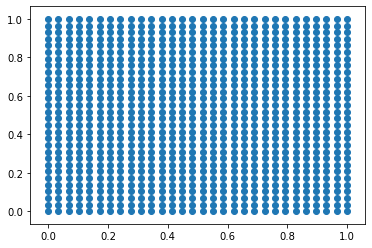

In [143]:
np.random.seed(64)
maxdegrees = 5
N = 30
x = np.linspace(0,1,N)  #np.sort(np.random.uniform(0, 1, N))
y = np.linspace(0,1,N) #np.sort(np.random.uniform(0, 1, N))
x_mesh, y_mesh = np.meshgrid(x,y)
x_flat = np.ravel(x_mesh) 
y_flat = np.ravel(y_mesh)

plt.scatter(x_flat, y_flat)
plt.show()

- Is it really justified to only use 20x20 points, we clearly see that this does not cover the entire mesh of x,y [0,1]. A qualitative study should requiere a min of 100x100 points. Burde vi ta den diskusjonen her, eller senere? Har nevnt det litt under også ettersom vi bruker 20x20 egt hele veien herifra

Results for ordinary least squares method
Degree: 0   mse train: 1.000000   mse test: 1.440723   r2_train: 0.000000   r2 test: -0.007569
Degree: 1   mse train: 0.552123   mse test: 0.525735   r2_train: 0.447877   r2 test: 0.537482
Degree: 2   mse train: 0.468758   mse test: 0.535676   r2_train: 0.531242   r2 test: 0.619697
Degree: 3   mse train: 0.274178   mse test: 0.417494   r2_train: 0.725822   r2 test: 0.556697
Degree: 4   mse train: 0.273511   mse test: 0.294854   r2_train: 0.726489   r2 test: 0.625667
Degree: 5   mse train: 0.258712   mse test: 0.365581   r2_train: 0.741288   r2 test: 0.702094

 Standard deviation and mean value of X_train and z_train, degree = 5
0.9759000729485332 1.7129155237073845e-16
1.0 -1.0685896612017132e-16




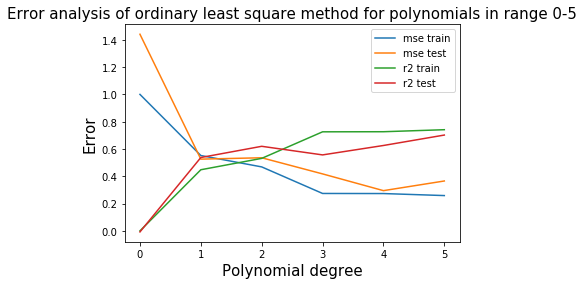

In [146]:
# Making meshgrid of datapoints and compute Franke's function
np.random.seed(64)

maxdegrees = 5 #Max degree of polynomial fit
N = 20 #Total datapoints
ts = 0.2 #Size of train test split
printData = False #Change to print X_train and z_train
scaling = True #Change to try without scaling

x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))
x_mesh, y_mesh = np.meshgrid(x,y)
x_flat = np.ravel(x_mesh) 
y_flat = np.ravel(y_mesh)

z = FrankeFunction(x_flat, y_flat, 0.15) #Change the third argument to vary the amount of stoicrastic noise

polydegree = np.zeros(maxdegrees+1)
r2_train = np.zeros(maxdegrees+1)
r2_test = np.zeros(maxdegrees+1)
mse_train = np.zeros(maxdegrees+1)
mse_test = np.zeros(maxdegrees+1)

# OLS regression for polynomials from 0 to maxdegrees
print("Results for ordinary least squares method")
for i in range(maxdegrees+1):
    degree = i
    polydegree[i] = degree
    X = create_X(x_flat, y_flat, degree)
    X_train, X_test, z_train, z_test = train_test_split(X,z, test_size=ts)
    
    if (scaling == True):
        X_train, X_test, z_train, z_test = scale(X_train, X_test, z_train, z_test) #Scale data with standard scaler
        
    # prediction
    beta = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ z_train
    zTilde = X_train @ beta
    zPredict = X_test @ beta
    
    # cost functions
    r2_train[i] = r2_score(z_train, zTilde) #Error analysis from error functions from lecture notes
    r2_test[i] = r2_score(z_test, zPredict)
    mse_train[i] = MSE(z_train, zTilde) 
    mse_test[i] = MSE(z_test, zPredict)
    
    print('Degree: %i   mse train: %.6f   mse test: %.6f   r2_train: %.6f   r2 test: %.6f'\
          %(degree, mse_train[i], mse_test[i], r2_train[i], r2_test[i]))

    
if (printData == True):
    print("\n", "X_train:", "\n")
    print(X_train, "\n")
    print("X_train shape: {}".format(X_train.shape))
    print("\n", "Z_train:", "\n", z_train, "\n")
    print("z_train shape: {}".format(z_train.shape), "\n")

    
print("\n", "Standard deviation and mean value of X_train and z_train, degree = %i"%degree)
print(np.std(X_train), np.mean(X_train))
print(np.std(z_train), np.mean(z_train))
print("\n")    

plt.plot(polydegree, mse_train, label='mse train')
plt.plot(polydegree, mse_test, label='mse test')
plt.plot(polydegree, r2_train, label='r2 train')
plt.plot(polydegree, r2_test, label='r2 test')
plt.title("Error analysis of ordinary least square method for polynomials in range 0-5")
plt.xlabel("Polynomial degree")
plt.ylabel("Error")
plt.legend()
plt.show()

From the printouts, its clear by both the R2 score and the mean squared error (MSE) that our polynomial fit impoves drasticly by improving the number of complexity to a maximum of 5. We will see later on that this trend does not traverse endlessly. In addition, normal distrobuted noise has a large impact on the model fit, anything above a std of 0.5 for the noise result in terrible MSE and R2-score, a lower degree of noise does affect the fit, but only marginal in comparisson. For the remainder of the project, we will mostly apply a stoicrastic noise with standard deviation of 0.15, and a dataset consiting of 20x20 points. The value of the meshgrid is choosen as small to better visualize various effects and properties, all though not exactly realistic. 

A suprising result from this model is that when we study the dependence of scaling the data. A scaled dataset results in the MSE beginning at 1 and gradually lowering to around 0.25, which is a decent result. However, the intial unscaled data yields a significantly lower MSE of our model fit, beginig at close to 0, and shrinking even more as the polynomial degree increase. Given that a fit of degree 0, is not an accurate description of a 5th order polynomial, this must be incorrect.   

In this exercise we decided to apply the StandardScaler() functionality included in Scikit-learn to scale the data of the design matrix X and the output z in a consistent matter. This function works by subtracting the sample mean from each datapoint and dividing by the standard deviation, providing a new dataset with mean value 0, and standard deviation 1, as seen in the printouts for polynomial degree 5. The scaling was implemented by fitting a scaler to the train data exclusivly, in order to maintain the stoicrastic nature of the data. Somewhat suprinsingly, scaling this dataset resulted in a massive difference in the model evaluation, even though the data was normalized between 0 and 1 initially. When printing out the data (printData = True), we see that the x-data in particular vary largly, up to 10^5 between various datapoints. This results in a weight beeing added to each points representing a priority or importance for the model. This is not desirable when implementing a regression model. By applying the standard scaling method, this problem is efficintly resolved, and we see a way more realistic outcome of our model fit. 


#### 3.2. Confidence intervals <a class="anchor" id="3.2"></a>

- $\mu_{\beta} \pm \frac{2\sigma_{\beta}}{\sqrt{n}}$

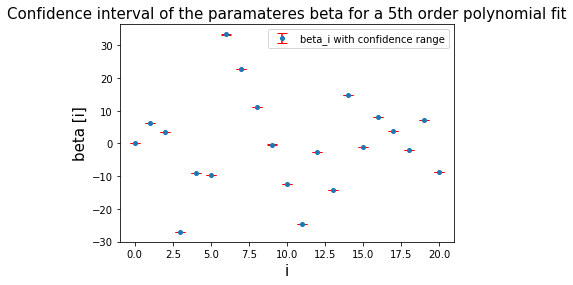

,Beta,+-
0,0.000000,0.000000
1,6.330254,0.003840
2,3.495914,0.003886
3,-27.017309,0.019153
4,-8.958082,0.010503
5,-9.703316,0.019303
6,33.341686,0.040857
7,22.765117,0.020236
8,11.019176,0.020060
9,-0.339818,0.040978


In [28]:
_str = len(beta)
variance = np.zeros(_str)
CI = np.zeros(_str)

for i in range(_str):
    variance[i] = 0.1**2 * np.linalg.pinv(X_train.T @ X_train)[i,i]
    CI[i] = 2*np.sqrt(variance[i])/np.sqrt(N)

print("")
plt.errorbar(np.arange(0,_str), beta, yerr=CI, fmt='o', ecolor='red', capsize=5, markersize=4, label='beta_i with confidence range')
plt.xlabel('i')
plt.ylabel('beta [i]')
plt.legend()
plt.title("Confidence interval of the paramateres beta for a 5th order polynomial fit")
plt.show()

table = pd.DataFrame({'Beta': beta, '+-': CI})
table

#### 3.3 Discussion on scaling <a class="anchor" id="3.3"></a>

### 4. Exercise 2 - Bias-variance trade-off and resampling techniques 
<a class="anchor" id="4"></a>


#### 4.1. Train vs test mse as function of complexity <a class="anchor" id="4.1"></a>

Here, we want to see how the train and test mse evolves with increasing complexity. Above polynomial degree 10 we can see the test error spiking, which indicates high variance. The lowest mse is found for a degree 9 polynomial fit, where mse = 0.2904. Polynomial degrees from 4-9 seem to give the best results. Polynomial degrees above this results in a spike in the mse, which indicates high variance when the complexity reaches this level. This is discussed further in the bias-variance section below.

Degree: 0   mse train: 1.000000   mse test: 1.440723
Degree: 1   mse train: 0.552123   mse test: 0.525735
Degree: 2   mse train: 0.468758   mse test: 0.535676
Degree: 3   mse train: 0.274178   mse test: 0.417494
Degree: 4   mse train: 0.273511   mse test: 0.294854
Degree: 5   mse train: 0.258712   mse test: 0.365581
Degree: 6   mse train: 0.224589   mse test: 0.352596
Degree: 7   mse train: 0.222232   mse test: 0.296650
Degree: 8   mse train: 0.229393   mse test: 0.361353
Degree: 9   mse train: 0.215597   mse test: 0.290401
Degree: 10   mse train: 0.206917   mse test: 0.643161
Degree: 11   mse train: 0.193310   mse test: 0.330206
Degree: 12   mse train: 0.198744   mse test: 6.440320
Degree: 13   mse train: 0.202599   mse test: 0.506152


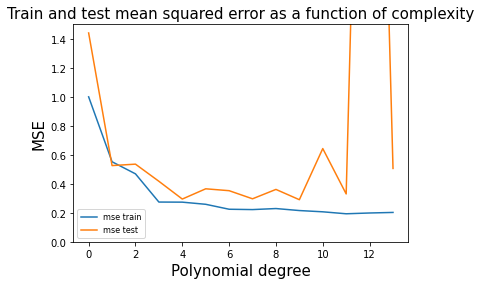

In [102]:
np.random.seed(64)

N = 20 #Small mesh size
maxdegrees = 14
scaling = True #Change to try without scaling

x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))
x_mesh, y_mesh = np.meshgrid(x,y)
x_flat = np.ravel(x_mesh) 
y_flat = np.ravel(y_mesh)

z = FrankeFunction(x_flat, y_flat, 0.15) #Change the third argument to vary the amount of stoicrastic noise

mse_train = np.zeros(maxdegrees)
mse_test = np.zeros(maxdegrees)

# OLS regression for polynomials from 0 to maxdegrees
polydegree = np.zeros(maxdegrees)
for i in range(maxdegrees):
    degree = i
    polydegree[i] = degree
    X = create_X(x_flat, y_flat, degree)
    X_train, X_test, z_train, z_test = train_test_split(X,z, test_size=0.2)
    
    if (scaling == True):
        X_train, X_test, z_train, z_test = scale(X_train, X_test, z_train, z_test) #Scale data with standard scaler
        
    # prediction
    beta = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ z_train
    zTilde = X_train @ beta
    zPredict = X_test @ beta
    
    # cost functions
    mse_train[i] = MSE(z_train, zTilde) 
    mse_test[i] = MSE(z_test, zPredict)
    
    print('Degree: %i   mse train: %.6f   mse test: %.6f'\
          %(degree, mse_train[i], mse_test[i]))

plt.plot(polydegree, mse_train, label='mse train')
plt.plot(polydegree, mse_test, label='mse test')
plt.ylim(0,1.5)
plt.legend()
plt.xlabel("Polynomial degree")
plt.ylabel("MSE")
plt.title("Train and test mean squared error as a function of complexity")
plt.show()

### Bootstrap: 
- Change train, test split: V
- Change datapoints: V
- Derive expression: 
- Brief summary of what the terms mean: V
- Why does the bias decrease, but var increase?: V 
- What is the effect of many/few datapoints (Dyve): 

#### 4.2. OLS regression with bootstrap resampling <a class="anchor" id="4.2"></a>

The code below performs an OLS regression with bootstrap resampling, using 1000 bootstraps. The results show a small improvement in the mse. The mse is 0.2672 for a degree 6 polynomial, compared to 0.29 previously found without bootstrap.

                 MSE         Bias      Variance
degree: 0      1.4407       1.4407      0.0000
degree: 1      0.5827       0.5797      0.0030
degree: 2      0.5599       0.5524      0.0075
degree: 3      0.2869       0.2710      0.0159
degree: 4      0.3324       0.3148      0.0176
degree: 5      0.4372       0.3745      0.0627
degree: 6      0.2672       0.2447      0.0226
degree: 7      0.3934       0.3323      0.0611
degree: 8      0.4674       0.3728      0.0946
degree: 9      1.8367       0.5225      1.3142
degree: 10      3.9732       0.5848      3.3884
degree: 11      3.4979       0.7771      2.7209



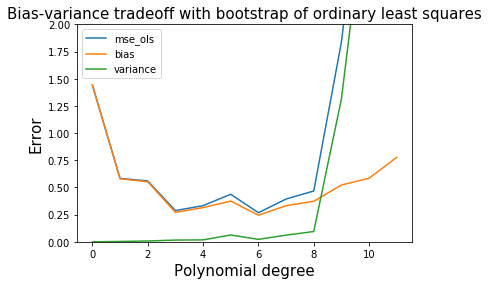

In [147]:
# Parameters

N = 20 # Change to alter total datapoints
ts = 0.2 #Change to alter train, test size

n_bootstraps = 1000 #Number of bootstraps
maxdegree = 12

# Create data
np.random.seed(64)
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))
x_mesh, y_mesh = np.meshgrid(x,y)
x_flat = np.ravel(x_mesh)
y_flat = np.ravel(y_mesh)

z = FrankeFunction(x_flat, y_flat, 0.15)

# Cost functions
mse = np.zeros(maxdegree)
r2 = np.zeros(maxdegree)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)

polydegree = np.zeros(maxdegree)
print("                 MSE         Bias      Variance")
for i in range(maxdegree):
    degree = i
    polydegree[i] = degree
    X = create_X(x_flat, y_flat, degree)

    X_train, X_test, z_train, z_test = train_test_split(X,z, test_size=ts)
    X_train, X_test, z_train, z_test = scale(X_train, X_test, z_train, z_test)

    z_pred = np.empty((z_test.shape[0], n_bootstraps))
    for j in range(n_bootstraps):
        x_bs,z_bs = resample(X_train, z_train)
        beta_ols = np.linalg.pinv(x_bs.T @ x_bs) @ x_bs.T @ z_bs
        z_pred[:,j] = X_test @ beta_ols
    
    mse[i] = np.mean(np.mean((z_test.reshape(-1,1) - z_pred)**2, axis=1, keepdims=True))
    bias[i] = np.mean((z_test.reshape(-1,1) - np.mean(z_pred, axis=1, keepdims=True))**2)
    variance[i] = np.mean(np.var(z_pred, axis=1, keepdims=True))
    
    print('degree: %i      %.4f       %.4f      %.4f'%(degree, mse[i], bias[i], variance[i])) 
    
print("")
plt.plot(polydegree, mse, label='mse_ols')
plt.plot(polydegree, bias, label='bias')
plt.plot(polydegree, variance, label='variance')
plt.title("Bias-variance tradeoff with bootstrap of ordinary least squares")
plt.xlabel('Polynomial degree')
plt.ylabel('Error')
plt.ylim(0,2)
plt.legend()
plt.show()

#### 4.3. Discussion of bias-variance trade-off <a class="anchor" id="4.3"></a>

The data is represented by the function y = f(x) + $\epsilon$, where $\epsilon$ is normally distributed with mean zero and variance equal to $\sigma²$. 

We have made a a model $\tilde{y} = X\beta$ approximating y, where $\beta$ is found by minimizing the cost function

$$
C(X,\beta) = \frac{1}{n}\sum_{i=0}^{n-1}{(y_i - \tilde{y_i})^2} = \mathbb{E}[(y - \tilde{y})²]
$$
Putting in our function in place of y gives
$$
\mathbb{E}[(y - \tilde{y})²] = \mathbb{E}[(f + \epsilon - \tilde{y})²]
$$

We can add and subtract $\mathbb{E}[y]$

$$
\mathbb{E}[(y - \tilde{y})²] = \mathbb{E}[(f + \epsilon - \tilde{y} + \mathbb{E}[y] - \mathbb{E}[y])²]
$$

From the definition of our function we have the following relations

$$
\mathbb{E}[y] = f
$$
$$
\mathbb{E}[\epsilon] = 0
$$
$$
var[y] = var[\epsilon] = \sigma²
$$

Using these relations, the cost function can be rewritten as

$$
\mathbb{E}[(y - \tilde{y})²] = \mathbb{E}[(f - \mathbb{E}[\tilde{y}])²] + var[\tilde{y}] + \epsilon² 
$$

$$
\mathbb{E}[(y - \tilde{y})²] = \frac{1}{n}\sum_i{(f_i - \mathbb{E}[\tilde{y}])²} + \frac{1}{n}\sum_i{(\tilde{y_i} - \mathbb{E}[\tilde{y}])²} + \epsilon²
$$

The first term represent the bias squared, the second the model variance and lastly $ \sigma^2 $ to denote the error originating from the noise. The bias of the model is a measure of how accuarate our model approximation is to the original problem, while the variance is usefull to meassure how our model fluxates in performence depending on the input data. Another way to define the model variance is how sensetive the model is on the traing data used. 

A common problem in machine learning algoritms is the bias-variance tradeoff, ie finding the appropriate model to minimize simantainously the bias and variance of the model. In this example we see that a polynomial of degree 6 is the best we can do. Beyond this point the variance and thus MSE explode to larger values, in a problem known as overfitting, or making our model to complex. The opposite, underfitting is present in polynomial degrees below 2, in this case the model bias is large, as obviously a 1st or 2nd degree polynomial is a bad model of a 5th order problem. The overfitting problem occurs because our model is designed very specifically for a set of data. Therefore, when altering the test data, our complex model does a terrible job adjusting. 

The bias-variance tradeoff is also largly dependent on the amount of data used for training and testing, a larger training set corresponds to a overall better model, and vice versa in the opposite case. 
When increasing the amount of datapoints in total, this explosion of the model variance does not apper to take place. However this is not the case, as the variance also in this case does in fact increase in increasing complexity, and the bias converge to a low variance. But given the amount of points, the value of the variance is simply too low compared to the bias to effectivly impact the mean squared error in any significant way. **Dyve må skrive noe om den flotte figuren sin, angående antall datapunkter.**

### 5. Exercise 3 - Cross validation as resampling technique, adding more complexity 
<a class="anchor" id="5"></a>

#### 5.1. OLS regression with cross-validation resampling <a class="anchor" id="5.1"></a>

The code below performs an OLS regression with cross-validation resampling. The results show an mse of 0.283 for a degree 6 polynomial fit. This is slightly better than without resampling, but not as good as with bootstrap. Varying k between 5 and 10 does not affect the result significantly.

degree: 0    MSE: 1.014967
degree: 1    MSE: 0.543536
degree: 2    MSE: 0.460891
degree: 3    MSE: 0.327560
degree: 4    MSE: 0.314723
degree: 5    MSE: 0.298608
degree: 6    MSE: 0.283374
degree: 7    MSE: 0.293943
degree: 8    MSE: 0.320473
degree: 9    MSE: 0.368816
degree: 10    MSE: 0.451438
degree: 11    MSE: 0.619847


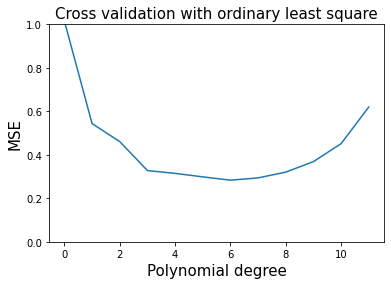

In [107]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Parameters
N = 20
maxdegree = 12
k = 10 #Number of folds
kfold = KFold(n_splits = k, shuffle=True, random_state=22) 

# Make dataset
np.random.seed(64)
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))
x_mesh, y_mesh = np.meshgrid(x,y)
x_flat = np.ravel(x_mesh)
y_flat = np.ravel(y_mesh)

z = FrankeFunction(x_flat, y_flat, 0.15)

mse_scikit_cv = False #Change to True to conduct cross-validation with scikit-learn

# Cost function
mse_ols_cvd = np.zeros(maxdegree)
polydegree = np.zeros(maxdegree)

for i in range(maxdegree):
    degree = i
    polydegree[i] = degree
    X = create_X(x_flat, y_flat, degree)
    mse_split = np.zeros(k)
    cv_split = 0
    for train_indexes, test_indexes in kfold.split(X):
        X_train = X[train_indexes]
        X_test = X[test_indexes]
        z_train = z[train_indexes]
        z_test = z[test_indexes]
        X_train, X_test, z_train, z_test = scale(X_train, X_test, z_train, z_test)

        beta = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ z_train
        z_pred = X_test @ beta
        
        mse_split[cv_split] = mean_squared_error(z_test, z_pred)
        
        cv_split += 1
    
    mse_ols_cvd[i] = np.mean(mse_split)
    
    #Compare with scikit-learn
    linreg = LinearRegression()
    mse_scikit_cv = np.mean(cross_val_score(linreg, X, z, scoring='neg_mean_squared_error', cv=kfold))

    
    if (mse_scikit_cv == True):
        print('degree: %i    MSE: %.6f    scikit mse: %.6f' %(degree, mse_ols_cvd[i], mse_scikit_cv))
    else:
        print('degree: %i    MSE: %.6f' %(degree, mse_ols_cvd[i]))

plt.plot(polydegree, mse_ols_cvd)
plt.ylim(0,1)
plt.title("Cross validation with ordinary least square")
plt.ylabel("MSE")
plt.xlabel("Polynomial degree")
plt.show()    


#### 5.2. Comments <a class="anchor" id="5.2"></a>

The results from the bootstrap resampling and cross-validation does vary in value, but show the same pattern in the mean squared error. When increasing the datapoints to say 200, the values are only marginaly differnt from eachother. Changing the number of folds in the cross validation does not tremendously impact the results. The major difference beeing the smoothness and consistancy in the curve, as is expected when performing a larger set of tests, which would be identical to increasing/deacrasing the number of bootstraps in the bootstrap resampling method. 

### 6. Exercise 4 - Ridge regression on the Franke function with resampling
<a class="anchor" id="4"></a>

In this task we want to find both the optimal polynomial degree and hyperparameter lambda. If done simultaneously, this quickly becomes computationally heavy, especially with bootstrap resampling. Our approach is therefore to first do a simple ridge model looping over lambda-values to get a picture of what values give the lowest mse. Then, we implement the different resampling methods in a loop over polynomial degrees where we test for the relevant lambda-values. 

#### 6.1. Simple ridge regression looping over lambdas <a class="anchor" id="6.1"></a>

The code below does a ridge regression without resampling and for a single given polynomial. The intended purpose of this simple model is to get a picture of what range of lambda-values are interesting when implementing bootstrap and cvd.

The results show that lambdas above 0.1 results in a rapidly increasing mse for every polynomial degree. The trend for different degrees is also a minimum between $10^{-4}$ and $10^{-2}$.

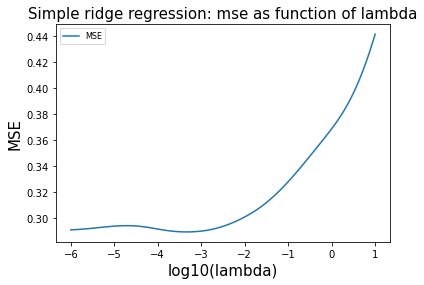

In [120]:
N = 20
np.random.seed(64)
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))
x_mesh, y_mesh = np.meshgrid(x,y)
x_flat = np.ravel(x_mesh)
y_flat = np.ravel(y_mesh)

z = FrankeFunction(x_flat, y_flat, 0.15)

n_lambdas = 100
lambdas = np.logspace(-6,1,n_lambdas)
degree = 6

#Error arrays
mse = np.zeros(n_lambdas)

X = create_X(x_flat, y_flat, degree)
X_train, X_test, z_train, z_test = train_test_split(X,z, test_size=0.2)
X_train, X_test, z_train, z_test = scale(X_train, X_test, z_train, z_test)
for i in range(n_lambdas):
    lmd = lambdas[i]
    
    I_ = np.eye(X_train.shape[1], X_train.shape[1])
    beta = np.linalg.pinv(X_train.T @ X_train + lmd*I_) @ X_train.T @ z_train
    z_pred = X_test @ beta
    mse[i] = mean_squared_error(z_test,z_pred)

plt.plot(np.log10(lambdas), mse, label="MSE")
plt.xlabel("log10(lambda)")
plt.ylabel("MSE")
plt.title('Simple ridge regression: mse as function of lambda')
plt.legend()
plt.show()

#### 6.2. Ridge regression with bootstrap and cross validation <a class="anchor" id="6.2"></a>

The code below performs a ridge regression with bootstrap and cross-validation resampling, with the chosen values for lambda based on the analysis above. 

The mse as function of complexity is then plottet for the chosen lambdas.

In [147]:
#Bootstrap parameters
n_bootstraps = 1000
maxdegree = 10

#cross_validation parameters
k = 10
kfold = KFold(n_splits = k, shuffle=True, random_state=22)

polydegrees = np.zeros(maxdegree)

#Error arrays
mse_ridge_bootstrap = np.zeros(maxdegree)
mse_ols_bootstrap = np.zeros(maxdegree)

bias_ridge_bootstrap = np.zeros(maxdegree)
bias_ols_bootstrap = np.zeros(maxdegree)

variance_ridge_bootstrap = np.zeros(maxdegree)
variance_ols_bootstrap = np.zeros(maxdegree)

mse_ridge_cvd = np.zeros(maxdegree)
mse_ols_cvd = np.zeros(maxdegree)


lmd = 0.1

for i in range(maxdegree):
    degree = i
    polydegrees[i] = degree
    print("Polynomial degree: %i" %(i))
    X = create_X(x_flat, y_flat, degree)
    X_train, X_test, z_train, z_test = train_test_split(X,z, test_size=0.2)
    X_train, X_test, z_train, z_test = scale(X_train, X_test, z_train, z_test)
    
    #Bootstrap
    z_pred_ridge_bootstrap = np.empty((z_test.shape[0], n_bootstraps))
    z_pred_ols_bootstrap = np.empty((z_test.shape[0], n_bootstraps))
    print("")
    print("Bootstrap")
    for j in range(n_bootstraps):

        x_bs,z_bs = resample(X_train,z_train)
        
        I_ = np.eye(X_train.shape[1], X_train.shape[1])
        
        beta_ridge_bootstrap = np.linalg.pinv(x_bs.T @ x_bs + lmd*I_) @ x_bs.T @ z_bs
        beta_ols_bootstrap = np.linalg.pinv(x_bs.T @ x_bs) @ x_bs.T @ z_bs
        
        z_pred_ols_bootstrap[:,j] = X_test @ beta_ols_bootstrap
        z_pred_ridge_bootstrap[:,j] = X_test @ beta_ridge_bootstrap
        
    #Bootstrap errors
    mse_ridge_bootstrap[i] = np.mean(np.mean((z_test.reshape(-1,1) - z_pred_ridge_bootstrap)**2, axis=1, keepdims=True))
    mse_ols_bootstrap[i] = np.mean(np.mean((z_test.reshape(-1,1) - z_pred_ols_bootstrap)**2, axis=1, keepdims=True))
    
    bias_ridge_bootstrap[i] = np.mean((z_test.reshape(-1,1) - np.mean(z_pred_ridge_bootstrap, axis=1, keepdims=True))**2)
    bias_ols_bootstrap[i] = np.mean((z_test.reshape(-1,1) - np.mean(z_pred_ols_bootstrap, axis=1, keepdims=True))**2)
    
    variance_ridge_bootstrap[i] = np.mean(np.var(z_pred_ridge_bootstrap, axis=1, keepdims=True))
    variance_ols_bootstrap[i] = np.mean(np.var(z_pred_ols_bootstrap, axis=1, keepdims=True)) 
    
    # Table for displaying mse, bias and variance for the different regression methods
    table_bs = pd.DataFrame({'regression type': ['OLS', 'ridge'],\
                          'mse': [mse_ols_bootstrap[i], mse_ridge_bootstrap[i]], \
                          'bias': [bias_ols_bootstrap[i], bias_ridge_bootstrap[i]], \
                          'variance':[variance_ols_bootstrap[i], variance_ridge_bootstrap[i]]})
    table_bs = table_bs.set_index('regression type')
    display(table_bs)
    print("")
    
    #Cross-validation
    cv_split = 0
    mse_ols_cvd_split = np.zeros(k)
    mse_ridge_cvd_split = np.zeros(k)
    print("")
    print("Cross-validation")
    for train_indexes, test_indexes in kfold.split(X):
        X_train = X[train_indexes]; X_test = X[test_indexes]
        z_train = z[train_indexes]; z_test = z[test_indexes]
        X_train, X_test, z_train, z_test = scale(X_train, X_test, z_train, z_test)
        
        I_ = np.eye(X_train.shape[1], X_train.shape[1])
        
        beta_ols_cvd = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ z_train
        z_pred_ols_cvd = X_test @ beta_ols_cvd
        
        beta_ridge_cvd = np.linalg.pinv(X_train.T @ X_train + lmd*I_) @ X_train.T @ z_train
        z_pred_ridge_cvd = X_test @ beta_ridge_cvd
        
        mse_ols_cvd_split[cv_split] = mean_squared_error(z_test, z_pred_ols_cvd)
        mse_ridge_cvd_split[cv_split] = mean_squared_error(z_test, z_pred_ridge_cvd)
    
        cv_split += 1
    
    # Cvd errors
    mse_ridge_cvd[i] = np.mean(mse_ridge_cvd_split)
    mse_ols_cvd[i] = np.mean(mse_ols_cvd_split)
    
    # Table for displaying mse, bias and variance for the different regression methods
    table_cvd = pd.DataFrame({'regression type': ['OLS', 'ridge'],\
                          'mse': [mse_ols_cvd[i], mse_ridge_cvd[i]]})
    table_cvd = table_cvd.set_index('regression type')
    display(table_cvd)
    print("")

Polynomial degree: 0

Bootstrap


,mse,bias,variance
regression type,,,
OLS,1.214698,1.214698,0.0
ridge,1.214698,1.214698,0.0




Cross-validation


,mse
regression type,
OLS,1.00605
ridge,1.00605



Polynomial degree: 1

Bootstrap


,mse,bias,variance
regression type,,,
OLS,0.482608,0.478797,0.003811
ridge,0.482600,0.478791,0.003809




Cross-validation


,mse
regression type,
OLS,0.449997
ridge,0.449996



Polynomial degree: 2

Bootstrap


,mse,bias,variance
regression type,,,
OLS,0.369114,0.363355,0.005759
ridge,0.368475,0.362824,0.005651




Cross-validation


,mse
regression type,
OLS,0.405773
ridge,0.405677



Polynomial degree: 3

Bootstrap


,mse,bias,variance
regression type,,,
OLS,0.351707,0.339268,0.012439
ridge,0.351146,0.342623,0.008524




Cross-validation


,mse
regression type,
OLS,0.372866
ridge,0.374981



Polynomial degree: 4

Bootstrap


,mse,bias,variance
regression type,,,
OLS,0.329436,0.312157,0.017279
ridge,0.337898,0.327756,0.010141




Cross-validation


,mse
regression type,
OLS,0.335136
ridge,0.368223



Polynomial degree: 5

Bootstrap


,mse,bias,variance
regression type,,,
OLS,0.309685,0.287795,0.021891
ridge,0.338194,0.327773,0.010421




Cross-validation


,mse
regression type,
OLS,0.319842
ridge,0.359926



Polynomial degree: 6

Bootstrap


,mse,bias,variance
regression type,,,
OLS,0.330582,0.292282,0.038300
ridge,0.324341,0.312520,0.011821




Cross-validation


,mse
regression type,
OLS,0.326664
ridge,0.355848



Polynomial degree: 7

Bootstrap


,mse,bias,variance
regression type,,,
OLS,0.461786,0.380836,0.080951
ridge,0.335057,0.321476,0.013581




Cross-validation


,mse
regression type,
OLS,0.334742
ridge,0.354227



Polynomial degree: 8

Bootstrap


,mse,bias,variance
regression type,,,
OLS,0.470132,0.364750,0.105382
ridge,0.409226,0.394374,0.014853




Cross-validation


,mse
regression type,
OLS,0.333201
ridge,0.352354



Polynomial degree: 9

Bootstrap


,mse,bias,variance
regression type,,,
OLS,0.449180,0.341478,0.107701
ridge,0.291413,0.276081,0.015332




Cross-validation


,mse
regression type,
OLS,0.338137
ridge,0.350377


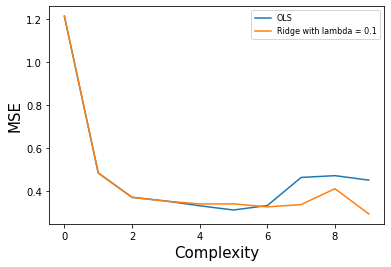

minimum mse with ridge: 0.29141
minimum mse with ols: 0.30969


In [149]:
# Plot results 

# MSE with bootstrap for ridge vs ols
plt.plot(polydegrees, mse_ols_bootstrap, label='OLS')
plt.plot(polydegrees, mse_ridge_bootstrap, label=('Ridge with lambda = 0.1'))
plt.xlabel('Complexity')
plt.ylabel('MSE')
plt.legend()
plt.show()

""""
# Bias vs variance with bootstrap
fig,ax = plt.subplots(1)
ax.plot(polydegrees, mse_ridge_bootstrap, label='mse')
ax.plot(polydegrees, bias_ridge_bootstrap, label='bias')
ax.plot(polydegrees, variance_ridge_bootstrap, label='variance')
ax.set_xlabel('Complexity')
ax.set_ylabel('Error')
ax.set_ylim(0,1)
ax.legend()
ax.set_title('MSE for different regression models')
plt.show()


fig,ax = plt.subplots(1, figsize=(10,6), sharey=True)
ax.plot(polydegrees, mse_ridge_cvd, label='ridge')
ax.plot(polydegrees, mse_ols_cvd, label='OLS')
ax.set_xlabel('complexity')
ax.set_ylabel('MSE')
ax.legend()
plt.title('mse errors for cvd')
plt.show()
"""
print("minimum mse with ridge: %.5f" %(np.amin(mse_ridge_bootstrap)))
print("minimum mse with ols: %.5f" %(np.amin(mse_ols_bootstrap)))

#### 6.2. Discussion of lambda dependence <a class="anchor" id="6.2"></a>

#### 6.3. Discussion of bias-variance trade-off  <a class="anchor" id="6.3"></a>

### 7. Exercise 5 - Lasso Regression on the Franke function with resampling
<a class="anchor" id="7"></a>

#### 7.1. Lasso regression

In [162]:
from sklearn.linear_model import Lasso

# Make data
N = 20
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))
x_mesh, y_mesh = np.meshgrid(x,y)
x_flat = np.ravel(x_mesh)
y_flat = np.ravel(y_mesh)
np.random.seed(64)

z = FrankeFunction(x_flat, y_flat, 0.15) 

# Bootstrap parameters
n_bootstraps = 500
maxdegree = 12

# Cross-validation parameters
k = 10
kfold = KFold(n_splits = k, shuffle=True, random_state=22)

polydegrees = np.zeros(maxdegree)

#Error arrays

# Bootstrap
mse_ols_bootstrap = np.zeros(maxdegree)
mse_ridge_bootstrap = np.zeros(maxdegree)
mse_lasso_bootstrap = np.zeros(maxdegree)

bias_ols_bootstrap = np.zeros(maxdegree)
bias_ridge_bootstrap = np.zeros(maxdegree)
bias_lasso_bootstrap = np.zeros(maxdegree)

variance_ols_bootstrap = np.zeros(maxdegree)
variance_ridge_bootstrap = np.zeros(maxdegree)
variance_lasso_bootstrap = np.zeros(maxdegree)

# cvd
mse_ols_cvd = np.zeros(maxdegree)
mse_ridge_cvd = np.zeros(maxdegree)
mse_lasso_cvd = np.zeros(maxdegree)

lmd = 0.1
for i in range(maxdegree):
    degree = i
    polydegrees[i] = degree
    print("Polynomial degree: %i" %(i))
    
    X = create_X(x_flat, y_flat, degree)

    # Bootstrap
    X_train, X_test, z_train, z_test = train_test_split(X,z, test_size=0.2)
    X_train, X_test, z_train, z_test = scale(X_train, X_test, z_train, z_test)
    
    z_pred_ridge_bootstrap = np.empty((z_test.shape[0], n_bootstraps))
    z_pred_ols_bootstrap = np.empty((z_test.shape[0], n_bootstraps))
    z_pred_lasso_bootstrap = np.empty((z_test.shape[0], n_bootstraps))
    
    print("")
    print("Bootstrap")
    for j in range(n_bootstraps):
        x_bs,z_bs = resample(X_train,z_train)
        
        beta_ols_bootstrap = np.linalg.pinv(x_bs.T @ x_bs) @ x_bs.T @ z_bs
        beta_ridge_bootstrap = np.linalg.pinv(x_bs.T @ x_bs + lmd*np.eye(x_bs.shape[1],x_bs.shape[1])) @ x_bs.T @ z_bs
        
        z_pred_ols_bootstrap[:,j] = X_test @ beta_ols_bootstrap
        z_pred_ridge_bootstrap[:,j] = X_test @ beta_ridge_bootstrap
        
        reglasso_bootstrap = Lasso(lmd, max_iter=1e5, tol=0.1)
        reglasso_bootstrap.fit(X_train, z_train)
        z_pred_lasso_bootstrap[:,j] = reglasso_bootstrap.predict(X_test)
    
    
    mse_ols_bootstrap[i] = np.mean(np.mean((z_test.reshape(-1,1) - z_pred_ols_bootstrap)**2, axis=1, keepdims=True))
    mse_ridge_bootstrap[i] = np.mean(np.mean((z_test.reshape(-1,1) - z_pred_ridge_bootstrap)**2, axis=1, keepdims=True))
    mse_lasso_bootstrap[i] = np.mean(np.mean((z_test.reshape(-1,1) - z_pred_lasso_bootstrap)**2, axis=1, keepdims=True))
    
    bias_ols_bootstrap[i] = np.mean((z_test.reshape(-1,1) - np.mean(z_pred_ols_bootstrap, axis=1, keepdims=True))**2)
    bias_ridge_bootstrap[i] = np.mean((z_test.reshape(-1,1) - np.mean(z_pred_ridge_bootstrap, axis=1, keepdims=True))**2)
    bias_lasso_bootstrap[i] = np.mean((z_test.reshape(-1,1) - np.mean(z_pred_lasso_bootstrap, axis=1, keepdims=True))**2)
    
    variance_ols_bootstrap[i] = np.mean(np.var(z_pred_ols_bootstrap, axis=1, keepdims=True))
    variance_ridge_bootstrap[i] = np.mean(np.var(z_pred_ridge_bootstrap, axis=1, keepdims=True))
    variance_lasso_bootstrap[i] = np.mean(np.var(z_pred_lasso_bootstrap, axis=1, keepdims=True))
    
    # Table for displaying mse, bias and variance for the different regression methods
    table_bs = pd.DataFrame({'regression type': ['OLS', 'ridge', 'lasso'],\
                          'mse': [mse_ols_bootstrap[i], mse_ridge_bootstrap[i], mse_lasso_bootstrap[i]], \
                          'bias': [bias_ols_bootstrap[i], bias_ridge_bootstrap[i], bias_lasso_bootstrap[i]], \
                          'variance':[variance_ols_bootstrap[i], variance_ridge_bootstrap[i], variance_lasso_bootstrap[i]]})
    table_bs = table_bs.set_index('regression type')
    display(table_bs)
    print("")
    
    
    # cvd
    cv_split = 0
    mse_ols_cvd_split = np.zeros(k)
    mse_ridge_cvd_split = np.zeros(k)
    mse_lasso_cvd_split = np.zeros(k)
    
    print("")
    print("Cross-validation")
    for train_indexes, test_indexes in kfold.split(X):
        
        # Split and scale
        X_train = X[train_indexes]
        X_test = X[test_indexes]
        z_train = z[train_indexes]
        z_test = z[test_indexes]
        X_train, X_test, z_train, z_test = scale(X_train, X_test, z_train, z_test)
        
        # Make beta
        I_ = np.eye(X_train.shape[1], X_train.shape[1])
        beta_ols_cvd = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ z_train
        beta_ridge_cvd = np.linalg.pinv(X_train.T @ X_train + lmd*I_) @ X_train.T @ z_train
        
        # Predictions
        z_pred_ols_cvd = X_test @ beta_ols_cvd
        z_pred_ridge_cvd = X_test @ beta_ridge_cvd
        
        reglasso_cvd = Lasso(lmd, max_iter=1e5, tol=0.1)
        reglasso_cvd.fit(X_train, z_train)
        z_pred_lasso_cvd = reglasso_cvd.predict(X_test)
        
        # Errors
        mse_ols_cvd_split[cv_split] = mean_squared_error(z_test, z_pred_ols_cvd)
        mse_ridge_cvd_split[cv_split] = mean_squared_error(z_test, z_pred_ridge_cvd)
        mse_lasso_cvd_split[cv_split] = mean_squared_error(z_test, z_pred_lasso_cvd)
        
        cv_split += 1
    
    # Cvd errors
    mse_ridge_cvd[i] = np.mean(mse_ridge_cvd_split)
    mse_ols_cvd[i] = np.mean(mse_ols_cvd_split)
    mse_lasso_cvd[i] = np.mean(mse_lasso_cvd_split)
    
    # Table for displaying mse, bias and variance for the different regression methods
    table_cvd = pd.DataFrame({'regression type': ['OLS', 'ridge', 'lasso'],\
                          'mse': [mse_ols_cvd[i], mse_ridge_cvd[i], mse_lasso_cvd[i]]})
    table_cvd = table_cvd.set_index('regression type')
    display(table_cvd)
    print("")
 


Polynomial degree: 0

Bootstrap


,mse,bias,variance
regression type,,,
OLS,0.822371,0.822371,0.000000e+00
ridge,0.822371,0.822371,0.000000e+00
lasso,0.822371,0.822371,9.495568e-66




Cross-validation


,mse
regression type,
OLS,1.007829
ridge,1.007829
lasso,1.007829



Polynomial degree: 1

Bootstrap


,mse,bias,variance
regression type,,,
OLS,0.476047,0.472496,3.550161e-03
ridge,0.476047,0.472499,3.547858e-03
lasso,0.502214,0.502214,1.451779e-32




Cross-validation


,mse
regression type,
OLS,0.510081
ridge,0.510080
lasso,0.530228



Polynomial degree: 2

Bootstrap


,mse,bias,variance
regression type,,,
OLS,0.493854,0.486866,6.987695e-03
ridge,0.493701,0.486789,6.911693e-03
lasso,0.522113,0.522113,1.124337e-32




Cross-validation


,mse
regression type,
OLS,0.479672
ridge,0.479631
lasso,0.525034



Polynomial degree: 3

Bootstrap


,mse,bias,variance
regression type,,,
OLS,0.371444,0.358694,1.275039e-02
ridge,0.360148,0.349446,1.070215e-02
lasso,0.365283,0.365283,1.386974e-32




Cross-validation


,mse
regression type,
OLS,0.387615
ridge,0.390643
lasso,0.525034



Polynomial degree: 4

Bootstrap


,mse,bias,variance
regression type,,,
OLS,0.440641,0.423462,1.717853e-02
ridge,0.442061,0.429888,1.217322e-02
lasso,0.596751,0.596751,1.604571e-32




Cross-validation


,mse
regression type,
OLS,0.366211
ridge,0.382970
lasso,0.525034



Polynomial degree: 5

Bootstrap


,mse,bias,variance
regression type,,,
OLS,0.423807,0.397252,2.655477e-02
ridge,0.407844,0.393575,1.426823e-02
lasso,0.592761,0.592761,1.328369e-32




Cross-validation


,mse
regression type,
OLS,0.353641
ridge,0.380055
lasso,0.525034



Polynomial degree: 6

Bootstrap


,mse,bias,variance
regression type,,,
OLS,0.391657,0.355149,3.650764e-02
ridge,0.356398,0.340320,1.607723e-02
lasso,0.460585,0.460585,1.292604e-32




Cross-validation


,mse
regression type,
OLS,0.355990
ridge,0.378560
lasso,0.525034



Polynomial degree: 7

Bootstrap


,mse,bias,variance
regression type,,,
OLS,0.286809,0.234607,5.220164e-02
ridge,0.297831,0.282513,1.531738e-02
lasso,0.495093,0.495093,1.040845e-32




Cross-validation


,mse
regression type,
OLS,0.365706
ridge,0.376751
lasso,0.525034



Polynomial degree: 8

Bootstrap


,mse,bias,variance
regression type,,,
OLS,0.470051,0.321973,1.480783e-01
ridge,0.373399,0.353315,2.008425e-02
lasso,0.442265,0.442265,9.145346e-33




Cross-validation


,mse
regression type,
OLS,0.376722
ridge,0.375222
lasso,0.525034



Polynomial degree: 9

Bootstrap


,mse,bias,variance
regression type,,,
OLS,0.639256,0.469096,1.701596e-01
ridge,0.305204,0.283882,2.132220e-02
lasso,0.398333,0.398333,1.021886e-32




Cross-validation


,mse
regression type,
OLS,0.397637
ridge,0.374759
lasso,0.525034



Polynomial degree: 10

Bootstrap


,mse,bias,variance
regression type,,,
OLS,0.634728,0.418894,2.158340e-01
ridge,0.442756,0.422909,1.984748e-02
lasso,0.537854,0.537854,1.088708e-32




Cross-validation


,mse
regression type,
OLS,0.426882
ridge,0.375274
lasso,0.525034



Polynomial degree: 11

Bootstrap


,mse,bias,variance
regression type,,,
OLS,0.749226,0.538588,2.106383e-01
ridge,0.458276,0.442372,1.590453e-02
lasso,0.471684,0.471684,1.788963e-32




Cross-validation


,mse
regression type,
OLS,0.447355
ridge,0.376186
lasso,0.525034


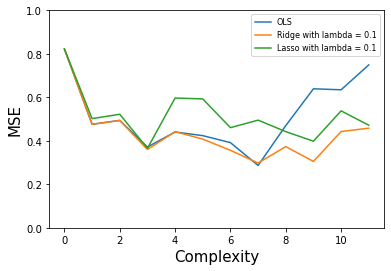

In [163]:
# Plot results

"""
#MSE with bootstrap for ols ridge vs Lasso
plt.plot(polydegrees, mse_ols_bootstrap, label='OLS')
plt.plot(polydegrees, mse_ridge_bootstrap, label=('Ridge with lambda = 0.1'))
plt.plot(polydegrees, mse_lasso_bootstrap, label=('Lasso with lambda = 0.1'))
plt.xlabel('Complexity')
plt.ylabel('MSE')
plt.ylim(0,1)
plt.legend()
plt.show()
"""
# Bias-variance for bootstrap
fig,ax = plt.subplots(3, figsize=(8,8))
ax[0].plot(polydegrees, mse_ridge_bootstrap, label='mse')
ax[0].plot(polydegrees, bias_ridge_bootstrap, label='bias')
ax[0].plot(polydegrees, variance_ridge_bootstrap, label='variance')
ax[0].set_ylim(0,1)
ax[0].legend()
ax[0].set_title('Ridge')

ax[1].plot(polydegrees, mse_ols_bootstrap, label='mse')
ax[1].plot(polydegrees, bias_ols_bootstrap, label='bias')
ax[1].plot(polydegrees, variance_ols_bootstrap, label='variance')
ax[1].legend()
ax[1].set_title('OLS')

ax[2].plot(polydegrees, mse_lasso_bootstrap, label='mse')
ax[2].plot(polydegrees, bias_lasso_bootstrap, label='bias')
ax[2].plot(polydegrees, variance_lasso_bootstrap, label='variance')
ax[2].legend()
ax[2].set_title('Lasso')

# cvd plot
fig,ax = plt.subplots(1)
ax.plot(polydegrees, mse_ridge_cvd, label='ridge')
ax.plot(polydegrees, mse_ols_cvd, label='OLS')
ax.plot(polydegrees, mse_lasso_cvd, label='lasso')
ax.set_xlabel('complexity')
ax.set_ylabel('MSE')
ax.legend()
plt.title('mse errors for cvd')
plt.show()

#### 7.2. Evaluation of methods  <a class="anchor" id="7.2"></a>

# References 
- [Scaling](https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35)